# Construct a trajectory several steps at a time

We aim to predict the next steps and actions based on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [3]:
import import_ipynb

from Process_Training_Data import class_to_action
from Process_Training_Data import norm

importing Jupyter notebook from Process_Training_Data.ipynb


## Multi-step model using single step-multioutput model

In [4]:
model = tf.keras.models.load_model('./data/single_step_sequential_model.h5')

In [5]:
data_stats = pd.read_csv("./data/data_stats.csv")

In [6]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [7]:
from simulate_clean import get_next_state
from clean_model import tc
from classes import FlightState

In [8]:
def distance_error(x, z, pitch, u, v):
    distancia = math.sqrt(x**2 + z**2)
    # distancia = math.sqrt(x**2 + z**2 + pitch**2 + u**2 + v**2)
    return distancia

In [44]:
def generate_trajectory(model, start, target, initial_action):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 6

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],target[6], target[7])
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],start[6], start[7])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = np.append(norm(distance_long[0:6], data_stats),distance_long[6:8])
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:5])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      tf_action = tf.squeeze(predictions, 0)
      np_action = np.array(tf_action)
      action = np_action[-1]
      actions.append(action)

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean > 0:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - current_state

        distance = np.append(norm(distance_long[0:6], data_stats), action)
        trajectory_generated.append(distance)
        input_eval = tf.expand_dims(trajectory_generated, 0)

        cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
        distancia_error = distance_error(*distance_long[0:5])

      elif boolean == 0:
        print("End")
        end_message = "End"
        break

      else:
        print("Error")
        end_message = "Error"
        break 
          

  return trajectory_generated, cost, distancia_error, actions, end_message

In [12]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [41]:
sample_id = 2
initial_action = np.array(samples['h_actions'][sample_id][0])
start = np.array(samples['initial_state'][sample_id])
target = np.array(samples['final_state'][sample_id])
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(norm(sample[0:6],data_stats))
teorico = np.array(teorico)

In [42]:
trajectory, cost, distancia_error, actions, end_message= generate_trajectory(model, start, target, initial_action)
trajectory = np.array(trajectory)



[-0.05538923 -0.0092268 ]
[-5.53892329e-02 -9.22679529e-03  3.78414697e+02]
[-0.06575654  0.02453014]
[-6.57565445e-02  2.45301407e-02  3.78414697e+02]
[-0.01582473  0.15157802]
[-1.58247333e-02  1.51578024e-01  3.78414697e+02]
End


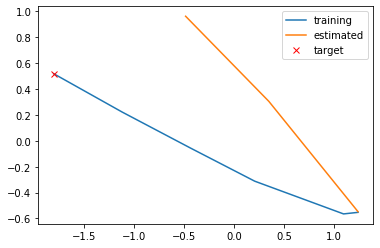

133.1471600998791
872.1700316338112


In [43]:
plt.plot(teorico[:,0], teorico[:,1],  label="training")
plt.plot(trajectory[:,0], trajectory[:,1], label="estimated")
D0 = norm([0,0,0,0,0,0], data_stats)
plt.plot(D0[0], D0[1],"rx", label="target")
plt.legend()
plt.show()
print(cost)
print(distancia_error)

In [45]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(results['h_actions'][sample_id][0])
    start = np.array(results['initial_state'][sample_id])
    target = np.array(results['final_state'][sample_id])
    start_time = time.time()
    trajectory, cost, distancia_error, actions, end_message = generate_trajectory(model, start, target, initial_action)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distancia_error
    results.at[sample_id, 'end_message'] = end_message
    

    

0
Model Error
Error
1
odeint esta hervi'o
Error
2
End
3
End
4
odeint esta hervi'o
Error
5
odeint esta hervi'o
Error
6
Model Error
Error
7
odeint esta hervi'o
Error
8
Model Error
Error
9
Model Error
Error
10
odeint esta hervi'o
Error
11
End
12
Model Error
Error
13
odeint esta hervi'o
Error
14
odeint esta hervi'o
Error
15
Model Error
Error
16
End
17
End
18
Model Error
Error
19
End
20
Model Error
Error
21
Model Error
Error
22
odeint esta hervi'o
Error
23
End
24
Model Error
Error
25
odeint esta hervi'o
Error
26
odeint esta hervi'o
Error
27
Model Error
Error
28
odeint esta hervi'o
Error
29
Model Error
Error
30
Model Error
Error
31
Model Error
Error
32
Model Error
Error
33
End
34
odeint esta hervi'o
Error
35
Model Error
Error
36
Model Error
Error
37
Model Error
Error
38
odeint esta hervi'o
Error
39
End
40
End
41
odeint esta hervi'o
Error
42
odeint esta hervi'o
Error
43
Model Error
Error
44
odeint esta hervi'o
Error
45
Model Error
Error
46
Model Error
Error
47
Model Error
Error
48
odeint esta

In [46]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table



,sample,result_end,result_error
h_cost,5215.39,1860.12,2221.65
h_distance,3.95573,820.564,1189.12
h_time,388.612,2.12929,2.46723


In [24]:
results.to_csv(r"./data/RNN_samples_metric.csv")